In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from sklearn import preprocessing

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV


from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randuni
#from keras.wrappers.scikit_learn import KerasClassifier


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
# load the car data dataset
try:
    data = pd.read_csv("mydata.csv", delimiter=",")
    print(" dataset has {} samples with {} features each.".format(*data.shape))
except:
    print("Dataset could not be loaded. Is the dataset missing?")

 dataset has 9134 samples with 6305 features each.


In [3]:
np.isnan(data).any().value_counts()

True     4032
False    2273
dtype: int64

In [4]:
#data = data.fillna(0)
data.replace(np.nan, 0, inplace=True)


In [5]:
#from sklearn.impute import SimpleImputer
#imp = SimpleImputer(missing_values='NaN', strategy='median')#, axis=1)
#imp.fit(data)
#data = imp.fit_transform(data)

In [6]:
data.isnull().mean()

Unnamed: 0                       0.0
person_id                        0.0
age                              0.0
status                           0.0
gender_source_value_F            0.0
                                ... 
condition_concept_id_46271022    0.0
condition_concept_id_46271075    0.0
condition_concept_id_46273463    0.0
condition_concept_id_46273487    0.0
condition_concept_id_46273652    0.0
Length: 6305, dtype: float64

In [7]:
np.isnan(data).any().value_counts()

False    6305
dtype: int64

In [8]:
#remove near zero variance features from total data
from sklearn.feature_selection import VarianceThreshold
threshold_n=0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
#sel = VarianceThreshold()

sel_var=sel.fit_transform(data)
data_without_zeroVfeature = data[data.columns[sel.get_support(indices=True)]]
data_without_zeroVfeature.shape

(9134, 5056)

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, random_state = 42)

for training_indices, testing_indices in split.split(data_without_zeroVfeature, data_without_zeroVfeature["status"]):
        stratified_training_data = data_without_zeroVfeature.loc[training_indices]
        stratified_testing_data = data_without_zeroVfeature.loc[testing_indices]

In [10]:
stratified_training_data.shape, stratified_testing_data.shape

((6393, 5056), (2741, 5056))

In [11]:
print(data["status"].value_counts()/len(data))

print(stratified_training_data["status"].value_counts()/len(stratified_training_data))
print(stratified_testing_data["status"].value_counts()/len(stratified_testing_data))

0.0    0.898402
1.0    0.101598
Name: status, dtype: float64
0.0    0.898326
1.0    0.101674
Name: status, dtype: float64
0.0    0.898577
1.0    0.101423
Name: status, dtype: float64


In [12]:
count_class_0, count_class_1 = stratified_training_data.status.value_counts()

df_class_0 = stratified_training_data[stratified_training_data['status'] == 0]
df_class_1 = stratified_training_data[stratified_training_data['status'] == 1]

Random over-sampling:
1.0    5743
0.0    5743
Name: status, dtype: int64


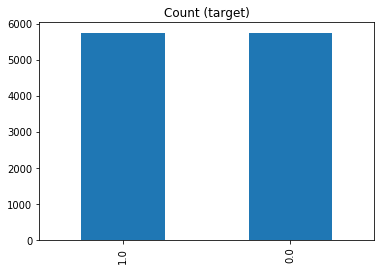

In [13]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.status.value_counts())

df_test_over.status.value_counts().plot(kind='bar', title='Count (target)');

In [14]:
#stratified_training_data_0_under = stratified_training_data_0.sample(count_class_1)
#df_test_under = pd.concat([stratified_training_data_0_under, stratified_training_data_1], axis=0)

#print('Random under-sampling:')
#print(df_test_under.status.value_counts())

#df_test_under.status.value_counts().plot(kind='bar', title='Count (target)');

In [15]:
from sklearn.feature_selection import VarianceThreshold
threshold_n=0.95
sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
#sel = VarianceThreshold()

sel_var=sel.fit_transform(data)
data[data.columns[sel.get_support(indices=True)]].shape

(9134, 5056)

In [16]:
#stratified_training_data

In [17]:
cols = list(df_test_over.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('status')) #Remove b from list
X_train = df_test_over[cols]
X_train.shape

(11486, 5055)

In [18]:
y_train = df_test_over["status"]
y_train.shape

(11486,)

In [19]:
cols = list(stratified_testing_data.columns.values) #Make a list of all of the columns in the df
cols.pop(cols.index('status')) #Remove b from list
X_test = stratified_testing_data[cols]
X_test.shape

(2741, 5055)

In [20]:
y_test = stratified_testing_data["status"]
y_test.shape

(2741,)

In [21]:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_minmax = min_max_scaler.transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train_minmax)
X_test = pca.transform(X_test_minmax)

In [23]:
explained_variance = pca.explained_variance_ratio_

In [24]:
explained_variance

array([0.01045113, 0.00266352, 0.00254031, 0.0024604 , 0.00238028,
       0.00235043, 0.00233469, 0.00230272, 0.0022833 , 0.0022736 ,
       0.00225342, 0.00223314, 0.00223051, 0.00220788, 0.00219348,
       0.00218684, 0.00215583, 0.00214965, 0.00212825, 0.00211988,
       0.00211302, 0.00210271, 0.00207617, 0.00207561, 0.00205633,
       0.00205268, 0.00204239, 0.00203927, 0.00201143, 0.00200706,
       0.00199182, 0.00198839, 0.00197495, 0.00196213, 0.00195315,
       0.00194484, 0.00193703, 0.00191962, 0.00191204, 0.00190742,
       0.00189949, 0.00188361, 0.00188105, 0.001877  , 0.00185798,
       0.00185307, 0.00184759, 0.00184425, 0.00183295, 0.00182759,
       0.00182302, 0.0018123 , 0.00180245, 0.00179068, 0.00178366,
       0.00177956, 0.00177402, 0.00176505, 0.00175588, 0.00175072,
       0.0017455 , 0.00173489, 0.0017326 , 0.00172391, 0.00171866,
       0.00171273, 0.00169929, 0.00169298, 0.00168462, 0.00168209,
       0.00167013, 0.00166382, 0.00165308, 0.00164853, 0.00164

In [25]:
#jbkjkbkb

In [26]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('pca', PCA()))
models.append(('NN', MLPClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('NB', GaussianNB()))
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))


# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

NN: 0.997214 (0.001940)
RF: 1.000000 (0.000000)
CART: 0.970746 (0.005528)
GB: 0.978061 (0.003296)
KNN: 0.986418 (0.002310)
SVM: 0.988595 (0.003403)
NB: 0.935661 (0.005869)
LR: 0.570083 (0.009800)
LDA: 0.570169 (0.009420)


# Following results without PCA and oversampling performance on training set in 10cv setup

SVM: 0.898452 (0.010047)
NB: 0.326127 (0.010025)
LR: 0.841384 (0.011822)
CART: 0.809769 (0.015354)
GB: 0.897905 (0.010295)
KNN: 0.876416 (0.013828)
RF: 0.898452 (0.010047)
LDA: 0.589707 (0.011376)

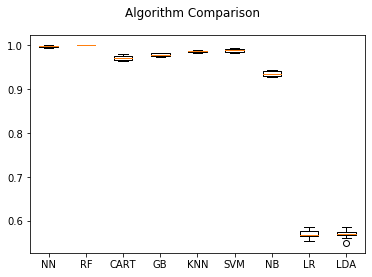

In [27]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Test Data Model Performances

In [28]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("NN: Classification Report")
print(classification_report(y_test, predictions))

0.8956585187887632
Confusion Matrix:
[[2451   12]
 [ 274    4]]

NN: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.94      2463
         1.0       0.25      0.01      0.03       278

    accuracy                           0.90      2741
   macro avg       0.57      0.50      0.49      2741
weighted avg       0.83      0.90      0.85      2741



In [29]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))

print("RF: Classification Report")
print(classification_report(y_test, y_pred))

[[2446   17]
 [ 276    2]]
0.8931047063115651
RF: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2463
         1.0       0.11      0.01      0.01       278

    accuracy                           0.89      2741
   macro avg       0.50      0.50      0.48      2741
weighted avg       0.82      0.89      0.85      2741



In [30]:
CART = DecisionTreeClassifier()
CART.fit(X_train, y_train)
predictions = CART.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("CART: Classification Report")
print(classification_report(y_test, predictions))

0.8653775994162715
Confusion Matrix:
[[2362  101]
 [ 268   10]]

CART: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93      2463
         1.0       0.09      0.04      0.05       278

    accuracy                           0.87      2741
   macro avg       0.49      0.50      0.49      2741
weighted avg       0.82      0.87      0.84      2741



In [31]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("GB: Classification Report")
print(classification_report(y_test, predictions))

0.8982123312659613
Confusion Matrix:
[[2461    2]
 [ 277    1]]

GB: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      2463
         1.0       0.33      0.00      0.01       278

    accuracy                           0.90      2741
   macro avg       0.62      0.50      0.48      2741
weighted avg       0.84      0.90      0.85      2741



In [32]:
#gb_accuracy = gb.score(X_test, y_test)*100     
#print('The accuracy of the predicting Work class Missing Values with GradientBoosting Model is ' + str(gb_accuracy)+'%')

In [33]:
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
predictions = KNN.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("KNN: Classification Report")
print(classification_report(y_test, predictions))

0.8890915724188252
Confusion Matrix:
[[2433   30]
 [ 274    4]]

KNN: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2463
         1.0       0.12      0.01      0.03       278

    accuracy                           0.89      2741
   macro avg       0.51      0.50      0.48      2741
weighted avg       0.82      0.89      0.85      2741



In [34]:
SVM = SVC(decision_function_shape="ovo").fit(X_train, y_train)
predictions = SVM.predict(X_test)
print(accuracy_score(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("SVM: Classification Report")
print(classification_report(y_test, predictions))

0.890550893834367
Confusion Matrix:
[[2437   26]
 [ 274    4]]

SVM: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      2463
         1.0       0.13      0.01      0.03       278

    accuracy                           0.89      2741
   macro avg       0.52      0.50      0.48      2741
weighted avg       0.82      0.89      0.85      2741



In [35]:
NB = GaussianNB()
NB.fit(X_train, y_train)
predictions = NB.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("NB: Classification Report")
print(classification_report(y_test, predictions))

0.8985771616198468
Confusion Matrix:
[[2463    0]
 [ 278    0]]

NB: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      2463
         1.0       0.00      0.00      0.00       278

    accuracy                           0.90      2741
   macro avg       0.45      0.50      0.47      2741
weighted avg       0.81      0.90      0.85      2741



/Users/friends/anaconda3/envs/udacity-ehr-env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
LG = LogisticRegression()
LG.fit(X_train, y_train)
predictions = LG.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("LG: Classification Report")
print(classification_report(y_test, predictions))

0.5902955125866473
Confusion Matrix:
[[1505  958]
 [ 165  113]]

LG: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.61      0.73      2463
         1.0       0.11      0.41      0.17       278

    accuracy                           0.59      2741
   macro avg       0.50      0.51      0.45      2741
weighted avg       0.82      0.59      0.67      2741



In [37]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
predictions = LDA.predict(X_test)
print(accuracy_score(y_test, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print()
print("LDA: Classification Report")
print(classification_report(y_test, predictions))


0.5968624589565852
Confusion Matrix:
[[1526  937]
 [ 168  110]]

LDA: Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.62      0.73      2463
         1.0       0.11      0.40      0.17       278

    accuracy                           0.60      2741
   macro avg       0.50      0.51      0.45      2741
weighted avg       0.82      0.60      0.68      2741

